In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

In [116]:
#path = "../Donnees_projet/Ensemble_apprentissage/"
#path = "../Donnees_projet/Ensemble_de_test/"
path_appr = "../../4A/Projet/Ensemble d'apprentissage/"
path_test = "../../4A/Projet/Ensemble de test/"

path = path_test

In [117]:
files = os.listdir(path)
nb_series = len(files)
print(nb_series)

128


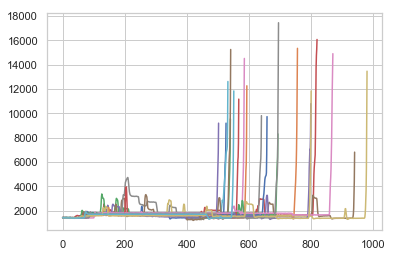

In [118]:
for i in range(0, 20) :
    data = pd.read_csv(path + files[i])
    plt.plot(data["FF_1"])
plt.show()

On observe que toutes les séries se terminent par un fort pic. **Est-il significatif, peut-on l'enlever ?**  On fait dans ce notebook le choix de l'enlever, sinon tous les plots se ressemblent à cause du tassement de l'échelle.

In [119]:
serie_1 = pd.read_csv(path + files[0], index_col=0)
print(serie_1.tail(15))
seuil_pic = 10

                   TIMESTAMP    FF_1
512  2013-01-03T14:55:16.505  1592.0
513  2013-01-03T14:55:17.505  1664.0
514  2013-01-03T14:55:18.505  1672.0
515  2013-01-03T14:55:19.505  1656.0
516  2013-01-03T14:55:20.505  1624.0
517  2013-01-03T14:55:21.505  1592.0
518  2013-01-03T14:55:22.505  1656.0
519  2013-01-03T14:55:23.505  2120.0
520  2013-01-03T14:55:24.505  3080.0
521  2013-01-03T14:55:25.505  4248.0
522  2013-01-03T14:55:26.505  5232.0
523  2013-01-03T14:55:27.505  5784.0
524  2013-01-03T14:55:28.505  6088.0
525  2013-01-03T14:55:29.505  6912.0
526  2013-01-03T14:55:30.505  9184.0


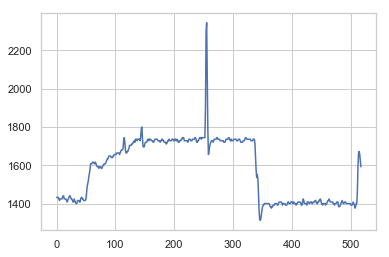

In [120]:
def enlever_pic(serie, seuil=10, plot=False) :
    """retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne le dataframe tronqué"""
    val_serie = serie["FF_1"].values
    if plot :
        plt.plot(val_serie)
    accr = val_serie[1:] - val_serie[:-1]
    for ind, val in enumerate(accr[::-1]) :
        if val < seuil_pic :
            if plot :
                plt.plot(val_serie[:-ind], color="red")
                plt.show()
            break
    else : 
        print("Aucun pic trouvé")
    return serie.drop(serie.index[-ind:])

a = enlever_pic(serie_1, 10)
plt.plot(a["FF_1"].values)
plt.show()

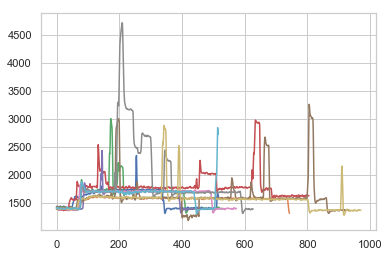

In [121]:
for i in range(0, 10) :
    data = enlever_pic(pd.read_csv(path + files[i]), seuil_pic)
    plt.plot(data["FF_1"])
plt.show()

Longueur des séries sans pic :

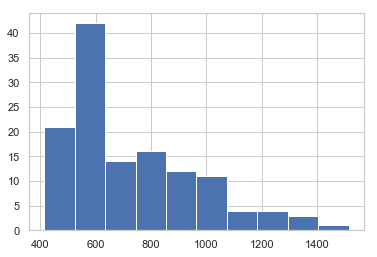

In [122]:
long = [enlever_pic(pd.read_csv(path + file)).shape[0] for file in files]
plt.hist(long)
plt.show()
longueur_min = min(long)

Toutes les séries sont de longueur différente, difficile donc de réaliser une ACP directement. On va plutôt étudier les coefficients de Fourier des séries. Pour avoir une comparaison faite sur les mêmes bases de Fourier, on ne conserve que les premiers coefficients, ceux qui sont communs à toutes les séries.

In [123]:
X_signal = [list(enlever_pic(pd.read_csv(path + files[num]))["FF_1"]) for num in range(nb_series)]
#print(X_signal)  # On a une liste de listes, chaque liste est une série de données

In [124]:
fftCoeff = []

for x in X_signal :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre)[:longueur_min])
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)

print(fftCoeff.shape)

(128, 414)


In [125]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff))

Text(0.5, 1.0, 'Distribution des premieres composantes')

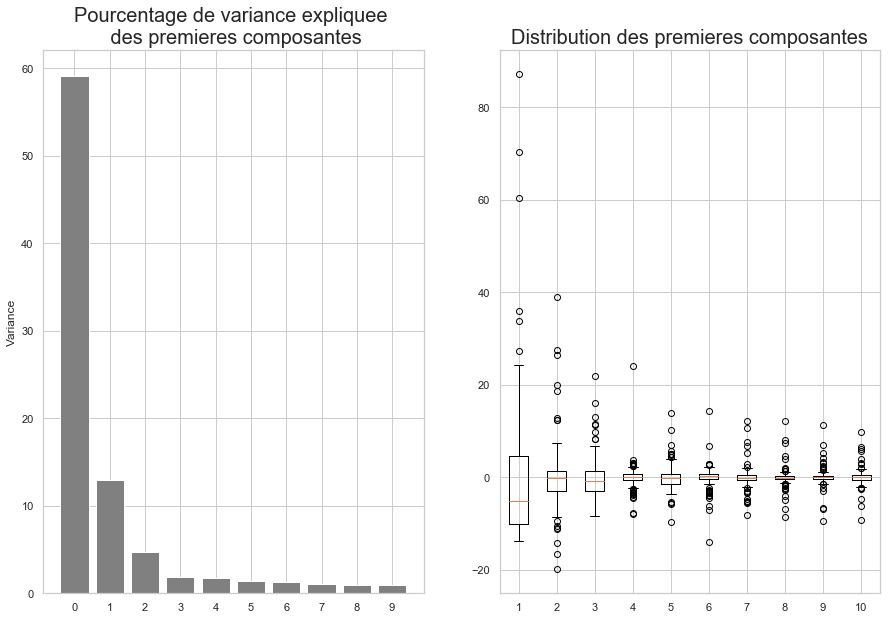

In [126]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_fft[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Projection des invididus sur les \n  deux premieres composantes')

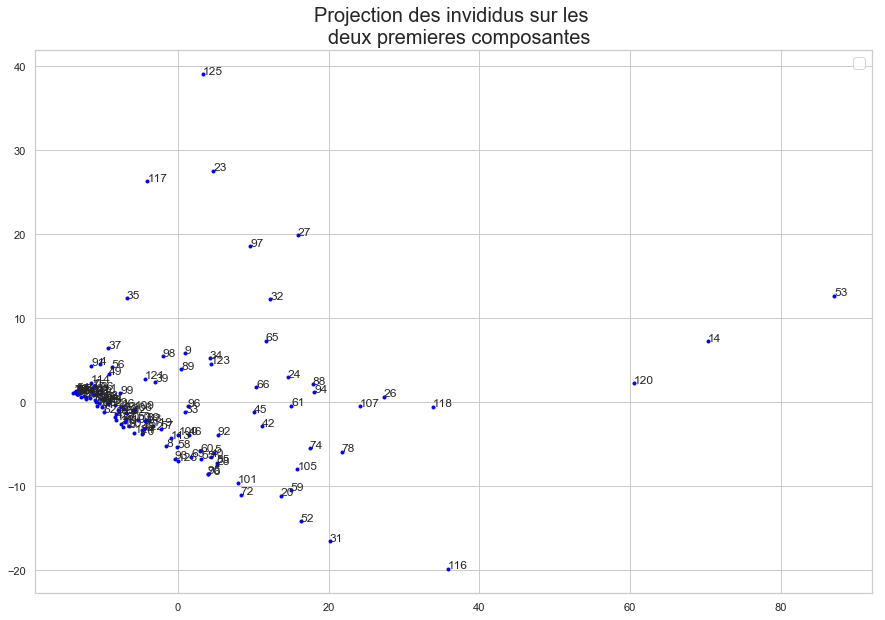

In [127]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
labels=[]
for x,y,s in zip(X_acp_fft[:,0], X_acp_fft[:,1], map(str,range(longueur_min))):
    ax.plot(x,y,marker=".", color="blue")
    ax.text(x, y, s)
       
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

Observation des signaux qui s'écartent des autres :

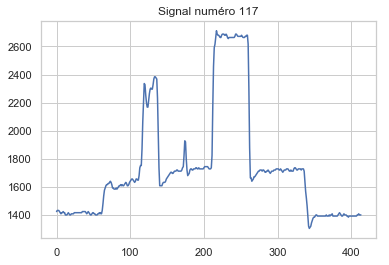

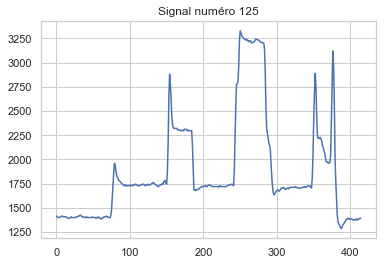

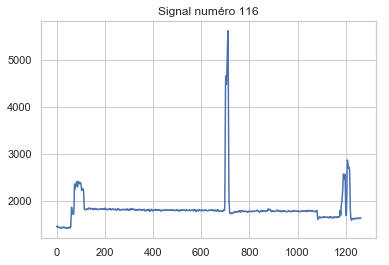

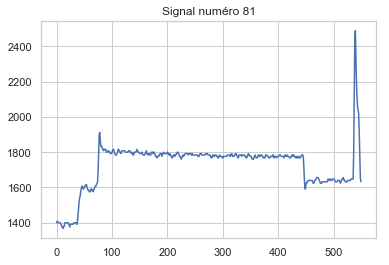

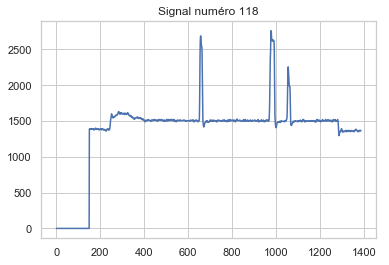

In [128]:
for num in [53, 127] :
#for num in range(50) :
    data = enlever_pic(pd.read_csv(path + files[num]))
    plt.plot(data["FF_1"])
    plt.title("Signal numéro " + str(num))
    plt.show()